# Fine-tune


In [1]:
import sys
sys.path.append('..')

import numpy as np

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import models
from torchvision import transforms as tfs
from torchvision.datasets import ImageFolder

### Visualize images

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

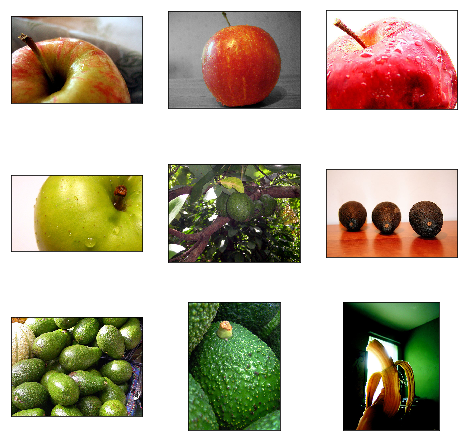

In [3]:
root_path = '/home/yang/dataset/imagenet/fruits/train/'
im_list = [os.path.join(root_path, 'apple', i) for i in os.listdir(root_path + 'apple')[:4]]
im_list += [os.path.join(root_path, 'avocado', i) for i in os.listdir(root_path + 'avocado')[:4]]
im_list += [os.path.join(root_path, 'banana', i) for i in os.listdir(root_path + 'banana')[:4]]
im_list += [os.path.join(root_path, 'kiwi', i) for i in os.listdir(root_path + 'kiwi')[:4]]
im_list += [os.path.join(root_path, 'watermelon', i) for i in os.listdir(root_path + 'watermelon')[:5]]

nrows = 3
ncols = 3
figsize = (8, 8)
_, figs = plt.subplots(nrows, ncols, figsize=figsize)
for i in range(nrows):
    for j in range(ncols):
        figs[i][j].imshow(Image.open(im_list[nrows*i+j]))
        figs[i][j].axes.get_xaxis().set_visible(False)
        figs[i][j].axes.get_yaxis().set_visible(False)
plt.show()

### Preprocess data

In [4]:
train_tf = tfs.Compose([
    tfs.RandomResizedCrop(224),
    tfs.RandomHorizontalFlip(),
    tfs.ToTensor(),
    tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

valid_tf = tfs.Compose([
    #tfs.Resize(256),
    tfs.CenterCrop(224),
    tfs.ToTensor(),
    tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Define dataset

In [5]:
train_set = ImageFolder('/home/yang/dataset/imagenet/fruits/train/', train_tf)
valid_set = ImageFolder('/home/yang/dataset/imagenet/fruits/val50/', valid_tf)

train_data = DataLoader(train_set, 64, True, num_workers=4)
valid_data = DataLoader(valid_set, 8, False, num_workers=4)

In [6]:
class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()

        # Normal convolution block followed by Batchnorm (CONV_3x3-->BN-->Relu)
        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        # Depthwise convolution block (CONV_BLK_3x3-->BN-->Relu-->CONV_1x1-->BN-->Relu)
        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
    
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
            )

        self.model = nn.Sequential(
            conv_bn(  3,  32, 2), 
            conv_dw( 32,  64, 1),
            conv_dw( 64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, 1000)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [7]:
model = MobileNet()
#print(model)

In [8]:
model = torch.nn.DataParallel(model).cuda()
#print(model)

In [9]:
params = torch.load('moblienet_30e.pth.tar')

### Method 1 - load directly

In [ ]:
model.load_state_dict(params)

### Method 2 - remove prefix in paramas

**Save model state_dict into a variable**

In [10]:
model_dict = model.state_dict()

**1. Filter out unnecessary keys**

In [11]:
pretrained_dict = {k: v for k, v in params.items() if k in model_dict}

**2. Overwrite entries in the existing state dict **

In [12]:
model_dict.update(pretrained_dict)

**3. Load the new state dict**

In [13]:
model.load_state_dict(model_dict)

### Finetune model

In [14]:
# the new defined layer have requires_grad=True by default.
model.fc = nn.Linear(2048, 5)
#model.fc.parameters.requires_grad
#model.fc = nn.Linear(2048, 2)

In [15]:
criterion = nn.CrossEntropyLoss()

# Sef different learning rates in different layers
optimizer = torch.optim.SGD([{'params':model.module.model.parameters(),'lr':1e-2},
                             {'params':model.module.fc.parameters(), 'lr':1e-3}], weight_decay=1e-4)

In [17]:
from utils import train
train(model, train_data, valid_data, 15, optimizer, criterion)

Epoch 0. Train Loss: 0.399191, Train Acc: 0.866243, Valid Loss: 0.747224, Valid Acc: 0.718750, Time 00:00:12
Epoch 1. Train Loss: 0.405505, Train Acc: 0.863038, Valid Loss: 0.716022, Valid Acc: 0.729167, Time 00:00:13
Epoch 2. Train Loss: 0.407094, Train Acc: 0.855483, Valid Loss: 0.705750, Valid Acc: 0.743056, Time 00:00:13
Epoch 3. Train Loss: 0.409433, Train Acc: 0.867731, Valid Loss: 0.705740, Valid Acc: 0.732639, Time 00:00:14
Epoch 4. Train Loss: 0.418427, Train Acc: 0.863954, Valid Loss: 0.704207, Valid Acc: 0.732639, Time 00:00:13
Epoch 5. Train Loss: 0.419768, Train Acc: 0.858516, Valid Loss: 0.694638, Valid Acc: 0.736111, Time 00:00:13
Epoch 6. Train Loss: 0.377409, Train Acc: 0.874657, Valid Loss: 0.719022, Valid Acc: 0.729167, Time 00:00:13
Epoch 7. Train Loss: 0.387515, Train Acc: 0.865442, Valid Loss: 0.689218, Valid Acc: 0.736111, Time 00:00:13
Epoch 8. Train Loss: 0.378958, Train Acc: 0.872596, Valid Loss: 0.692151, Valid Acc: 0.739583, Time 00:00:13
Epoch 9. Train Loss

### Save model

In [ ]:
torch.save(model.state_dict(), "mobienet_30e.pth.tar")

### Load save model

When we saved our pretrained model, we could load it without trainning again.

In [ ]:
mobilenet_model = MobileNet()

# transform the model to DataParallel
mobilenet_model = torch.nn.DataParallel(mobilenet_model).cuda()

# load params into a variable
params = torch.load('mobienet_30e.pth.tar')['state_dict']

# load params to model
mobilenet_model.load_state_dict(params)

## Validation

In [ ]:
model = model.eval()

In [ ]:
im1 = Image.open('/home/yang/dataset/imagenet/fruits/val/kiwi/756419172.jpg')
im1

## Result

In [ ]:
im = valid_tf(im1)
out = model(Variable(im.unsqueeze(0),volatile=True).cuda())
pred_label = out.max(1)[1].data[0]
print('predict label: {}'.format(train_set.classes[pred_label]))